In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D

/Users/mammadli/miniconda3/envs/py_jop/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


### Load .csv files, drop dublicates and non-netflow data, save in parquet file format

In [2]:
df_ToN = pd.read_parquet('../data/parquet/netflow/no_ip_port/NF-ToN-IoT_chunks')
df_BoT = pd.read_parquet('../data/parquet/netflow/no_ip_port/NF-BoT-IoT_chunks')

In [3]:
df_BoT.describe()

,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
count,40042.000000,40042.000000,4.004200e+04,4.004200e+04,40042.00000,40042.000000,40042.000000,4.004200e+04,40042.000000
mean,6.274786,13.023036,1.355682e+05,1.023238e+05,156.87663,63.936567,25.253559,3.735828e+06,0.922207
std,2.131099,29.816940,1.828307e+06,3.178444e+06,940.43938,738.573295,8.177419,1.322323e+06,0.267849
min,1.000000,0.000000,2.800000e+01,0.000000e+00,1.00000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.000000,7.000000,5.660000e+02,6.497500e+02,5.00000,4.000000,27.000000,4.258105e+06,1.000000
50%,6.000000,7.000000,6.920000e+02,7.700000e+02,5.00000,4.000000,27.000000,4.275224e+06,1.000000
75%,6.000000,7.000000,8.130000e+02,1.340000e+03,6.00000,4.000000,30.000000,4.287516e+06,1.000000
max,17.000000,244.000000,2.282235e+08,2.432197e+08,37817.00000,61110.000000,214.000000,4.294967e+06,1.000000


In [4]:
df_ToN.describe()

,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
count,381199.000000,381199.000000,3.811990e+05,3.811990e+05,3.811990e+05,3.811990e+05,381199.000000,3.811990e+05,381199.000000
mean,6.605361,20.778509,4.394665e+03,6.584151e+03,5.531398e+01,2.956658e+01,24.779173,2.180165e+04,0.860868
std,2.602404,33.331766,3.384967e+05,2.102151e+05,5.488978e+03,2.766541e+03,6.860745,2.265980e+05,0.346085
min,1.000000,0.000000,2.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,6.000000,7.000000,4.620000e+02,6.830000e+02,4.000000e+00,4.000000e+00,26.000000,1.560000e+02,1.000000
50%,6.000000,7.000000,5.450000e+02,2.239000e+03,5.000000e+00,6.000000e+00,27.000000,3.870000e+02,1.000000
75%,6.000000,7.178000,7.250000e+02,3.812000e+03,6.000000e+00,1.000000e+01,27.000000,1.667000e+03,1.000000
max,58.000000,251.000000,7.941590e+07,7.016518e+07,1.221043e+06,1.349068e+06,219.000000,4.294849e+06,1.000000


In [5]:
df1 = df_BoT.sample(n=2000, random_state=1)
df1.shape

(2000, 9)

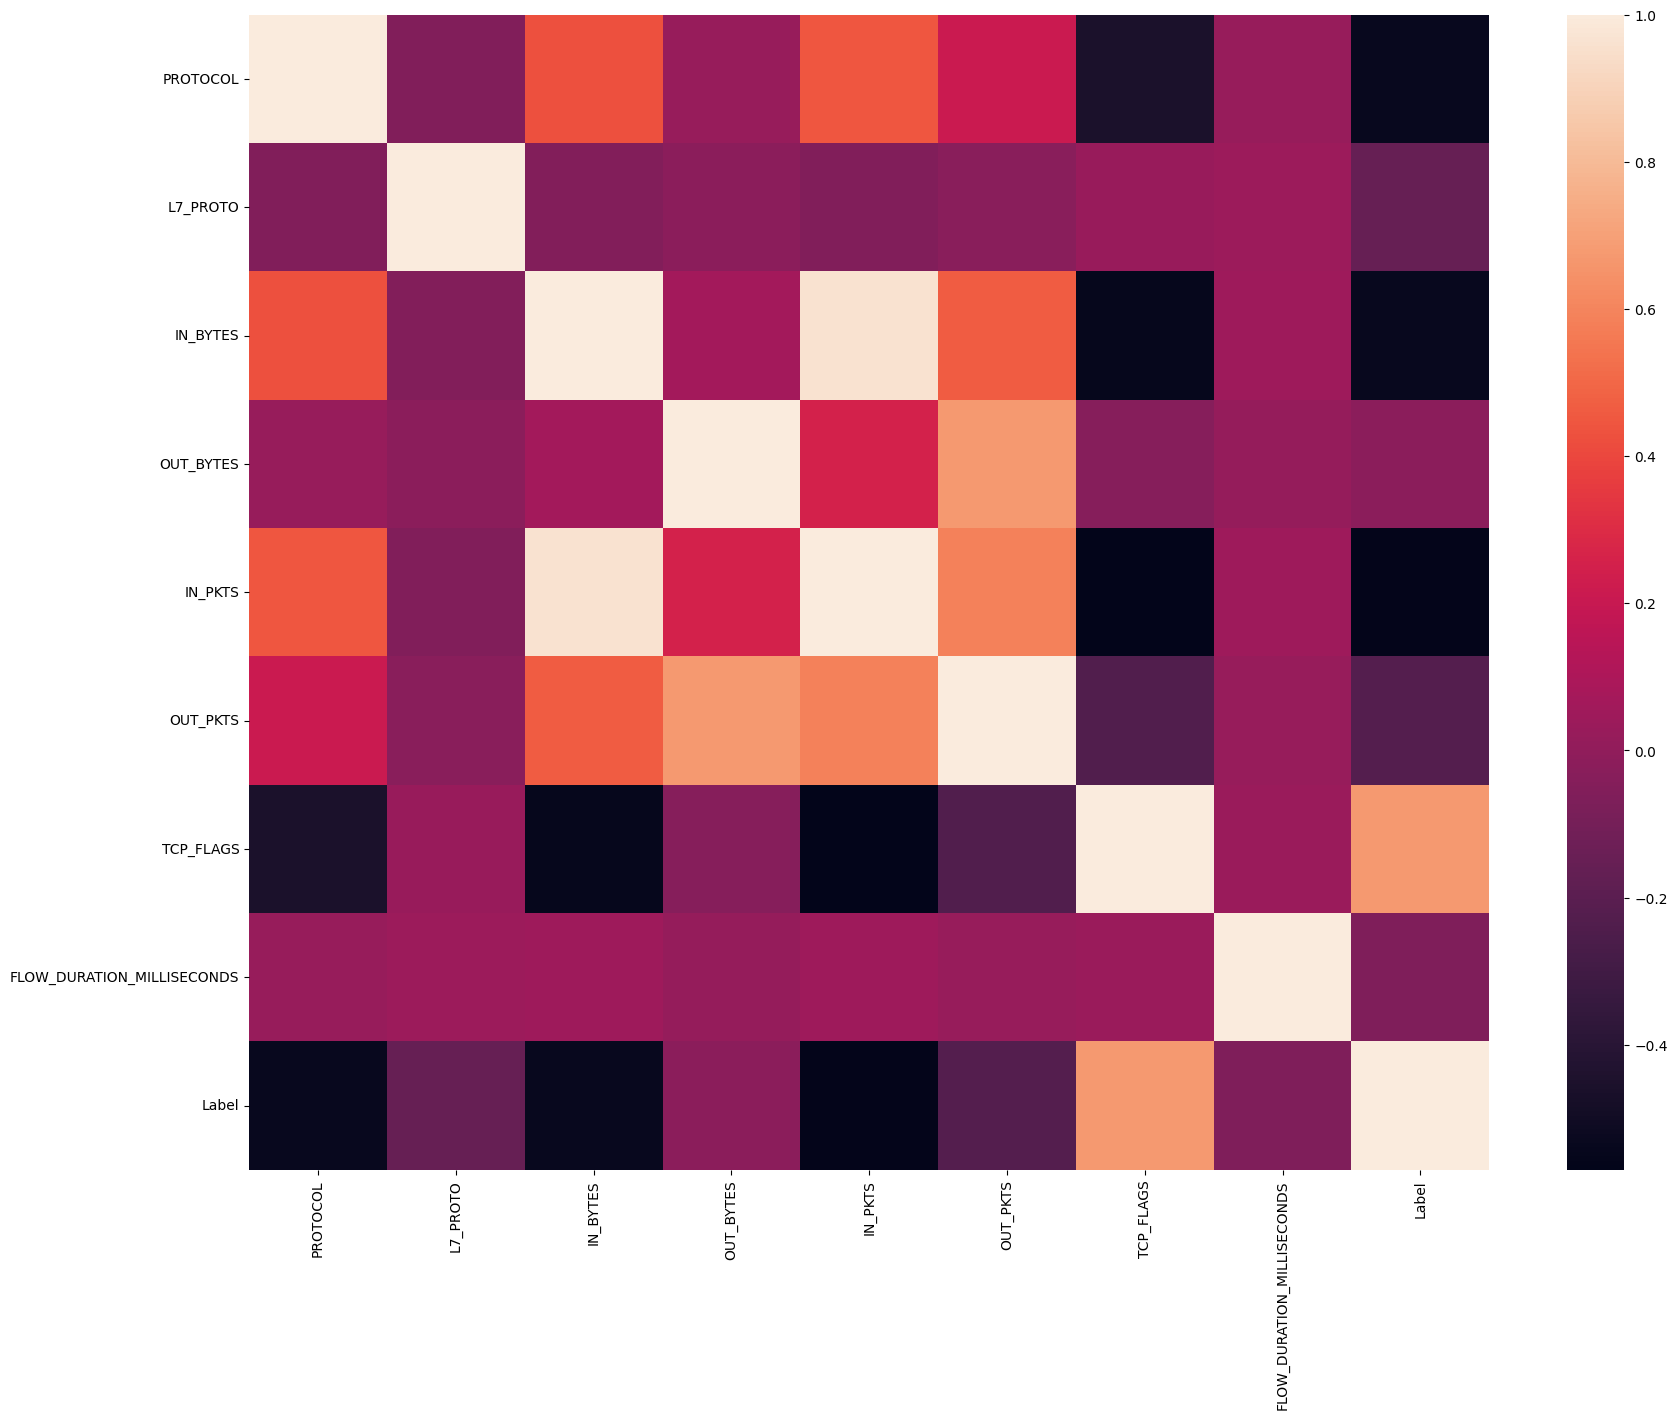

In [6]:
matrix = df1.corr()
plt.subplots(figsize=(20,15))
sn.heatmap(matrix)#, annot=True)
plt.show()

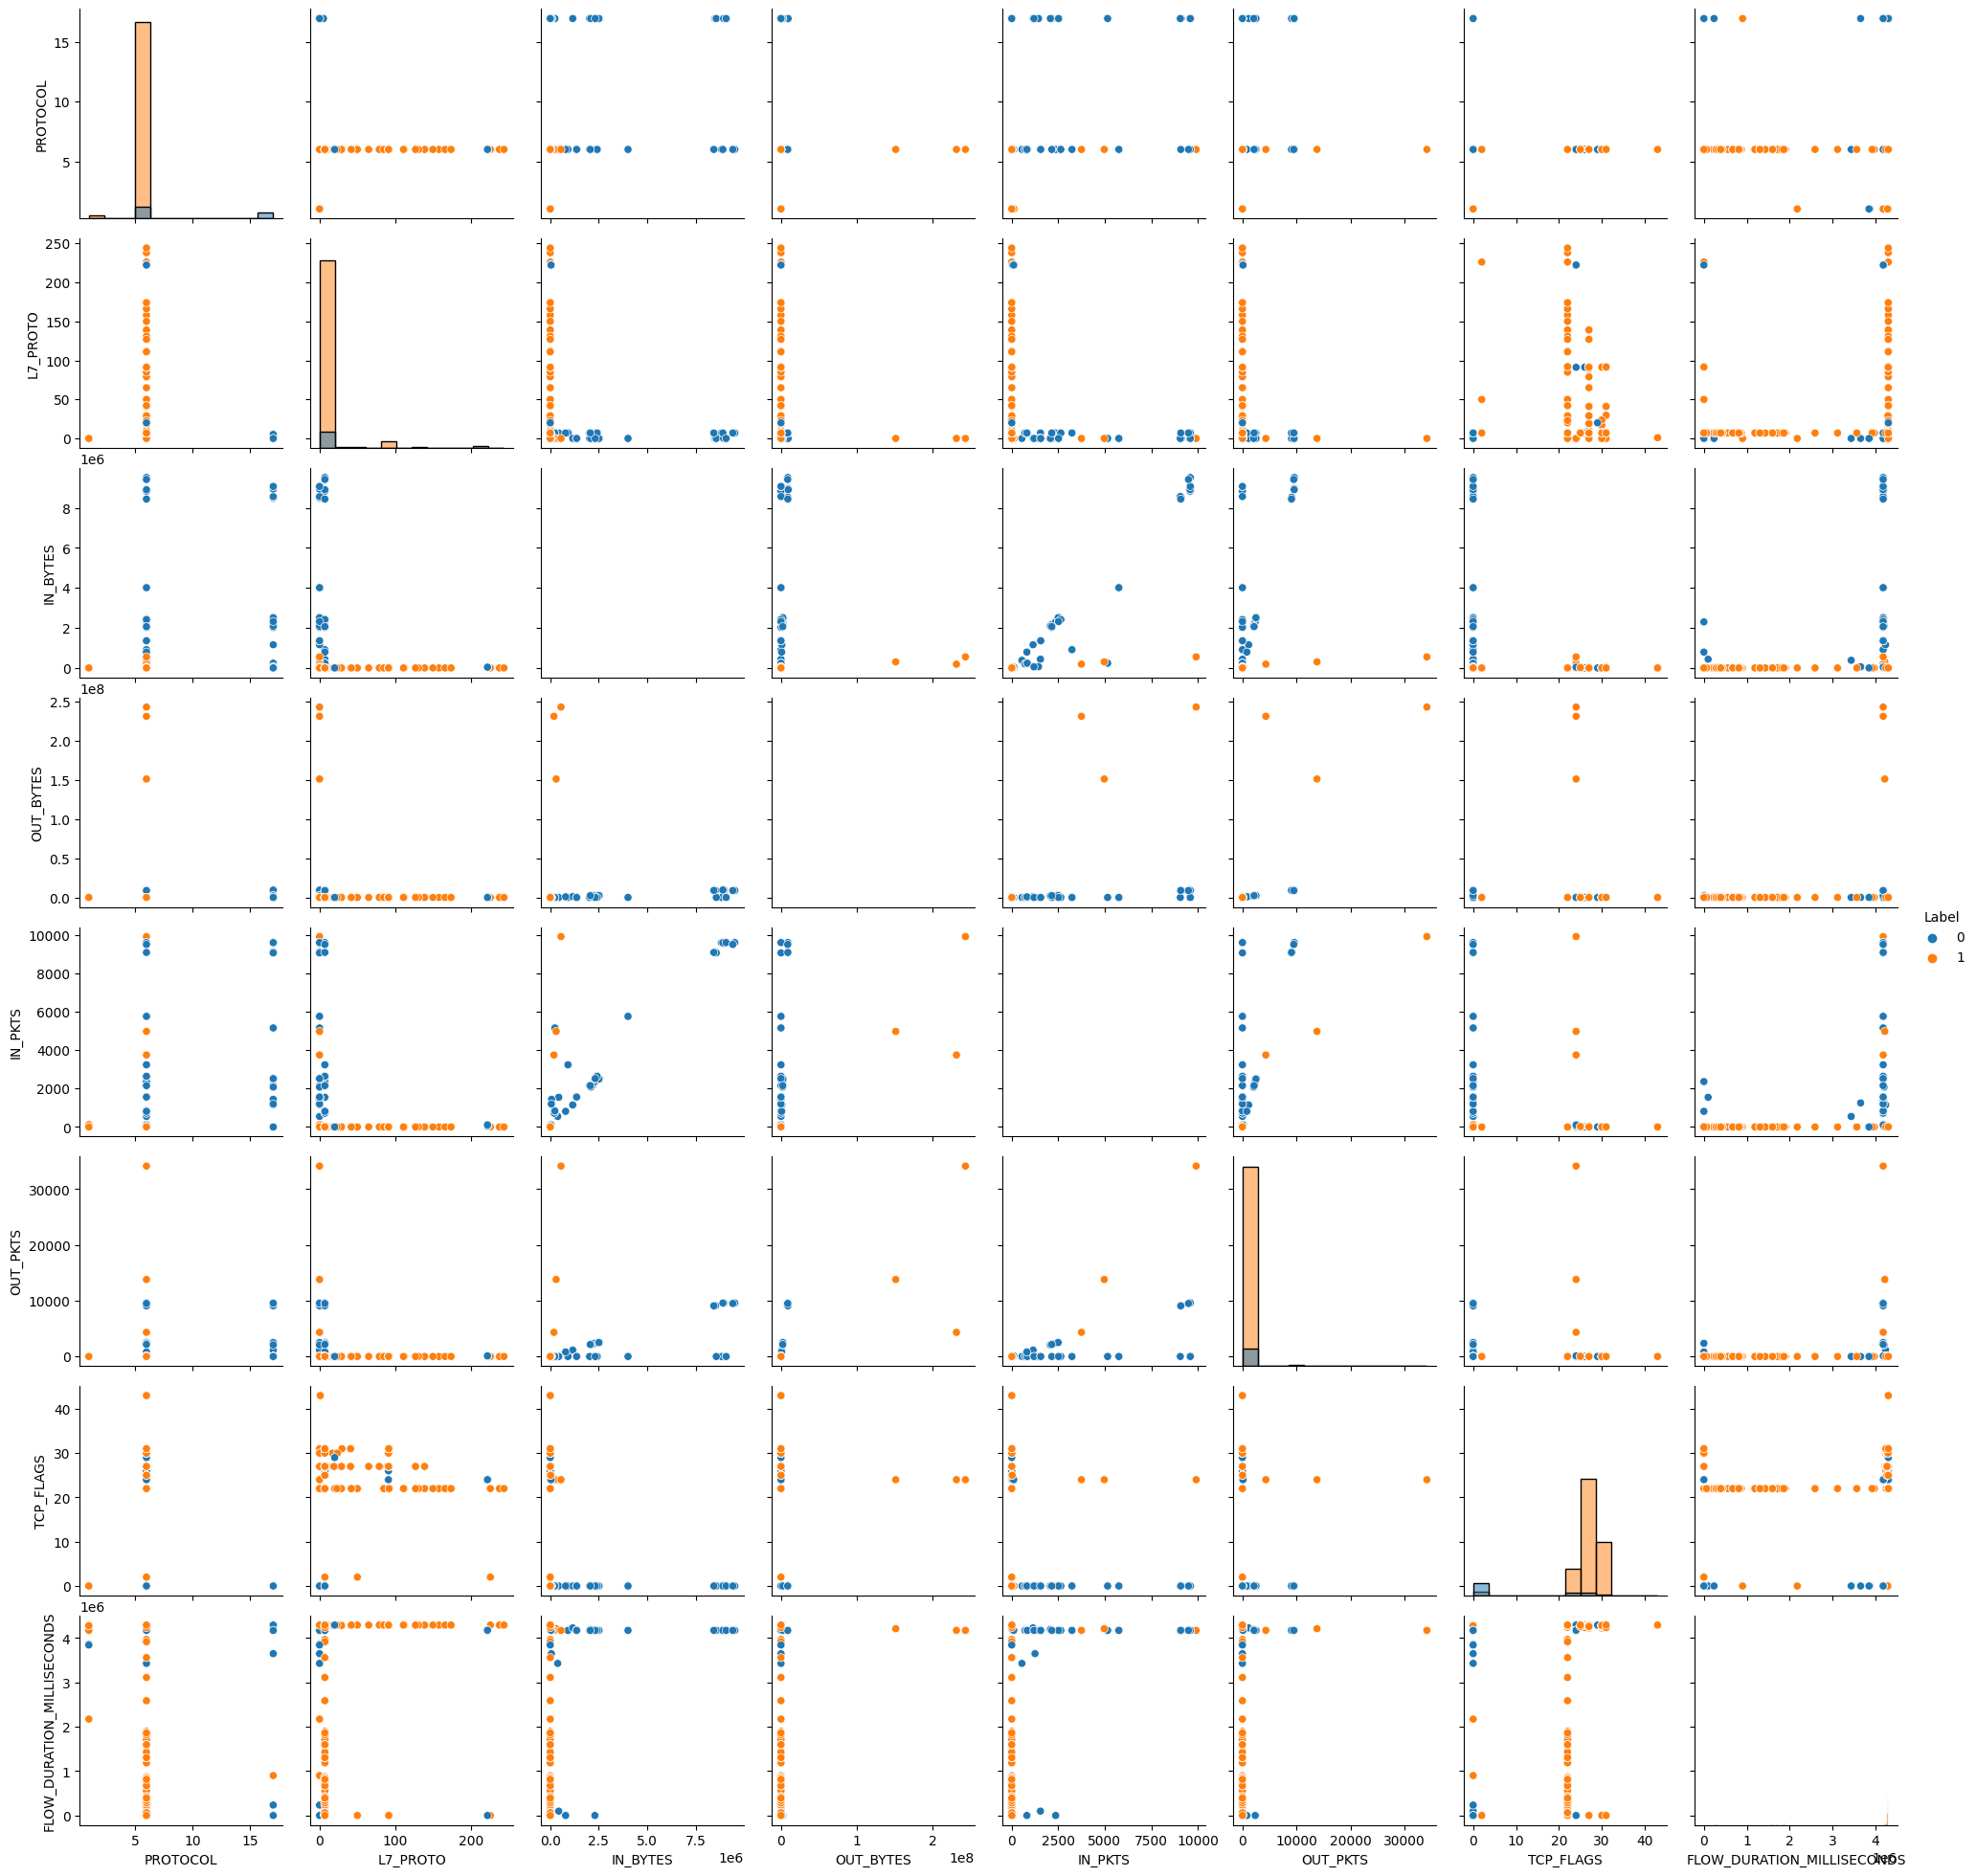

In [7]:
g = sn.PairGrid(df1, hue="Label")
g.map_diag(sn.histplot)
g.map_offdiag(sn.scatterplot)
g.add_legend()

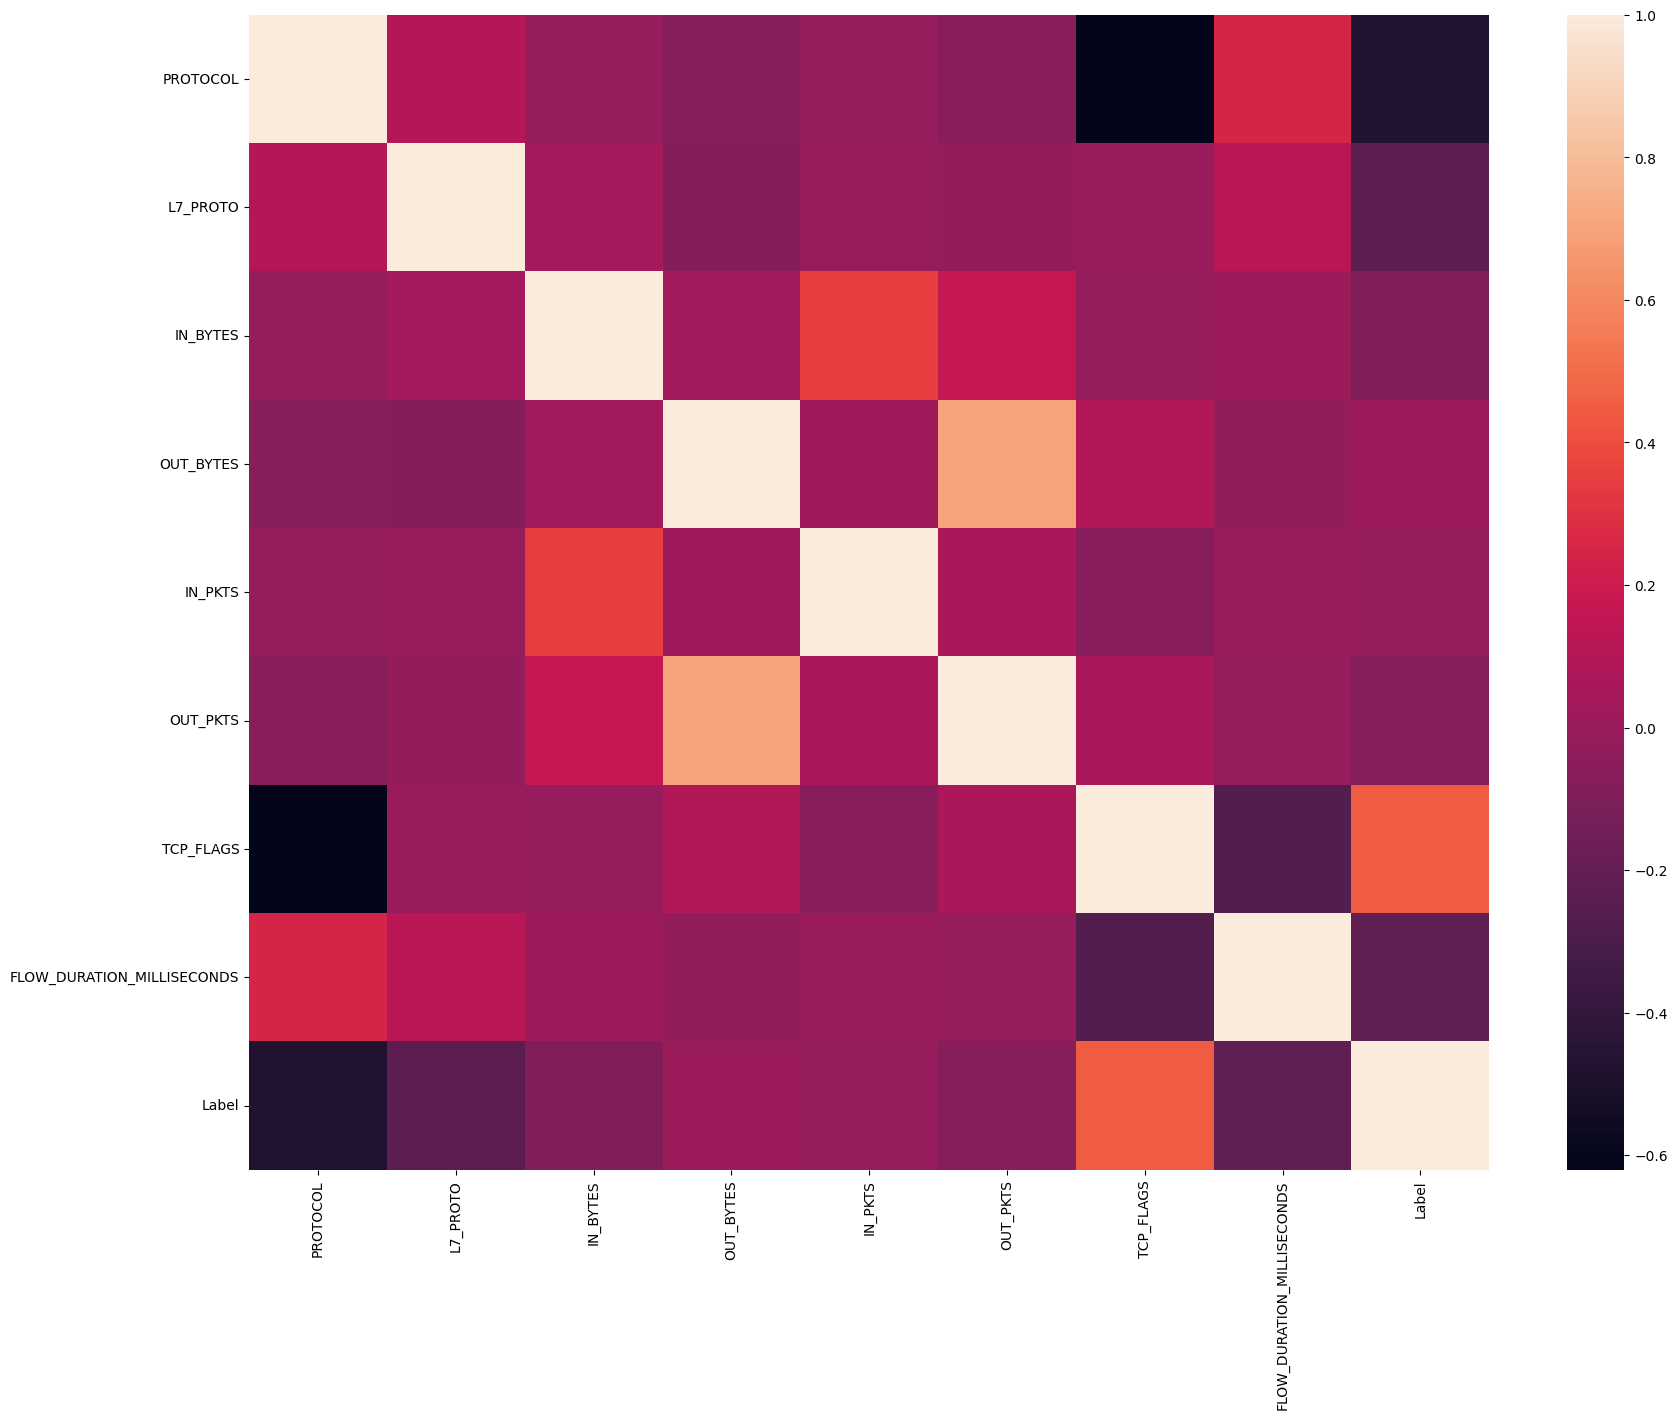

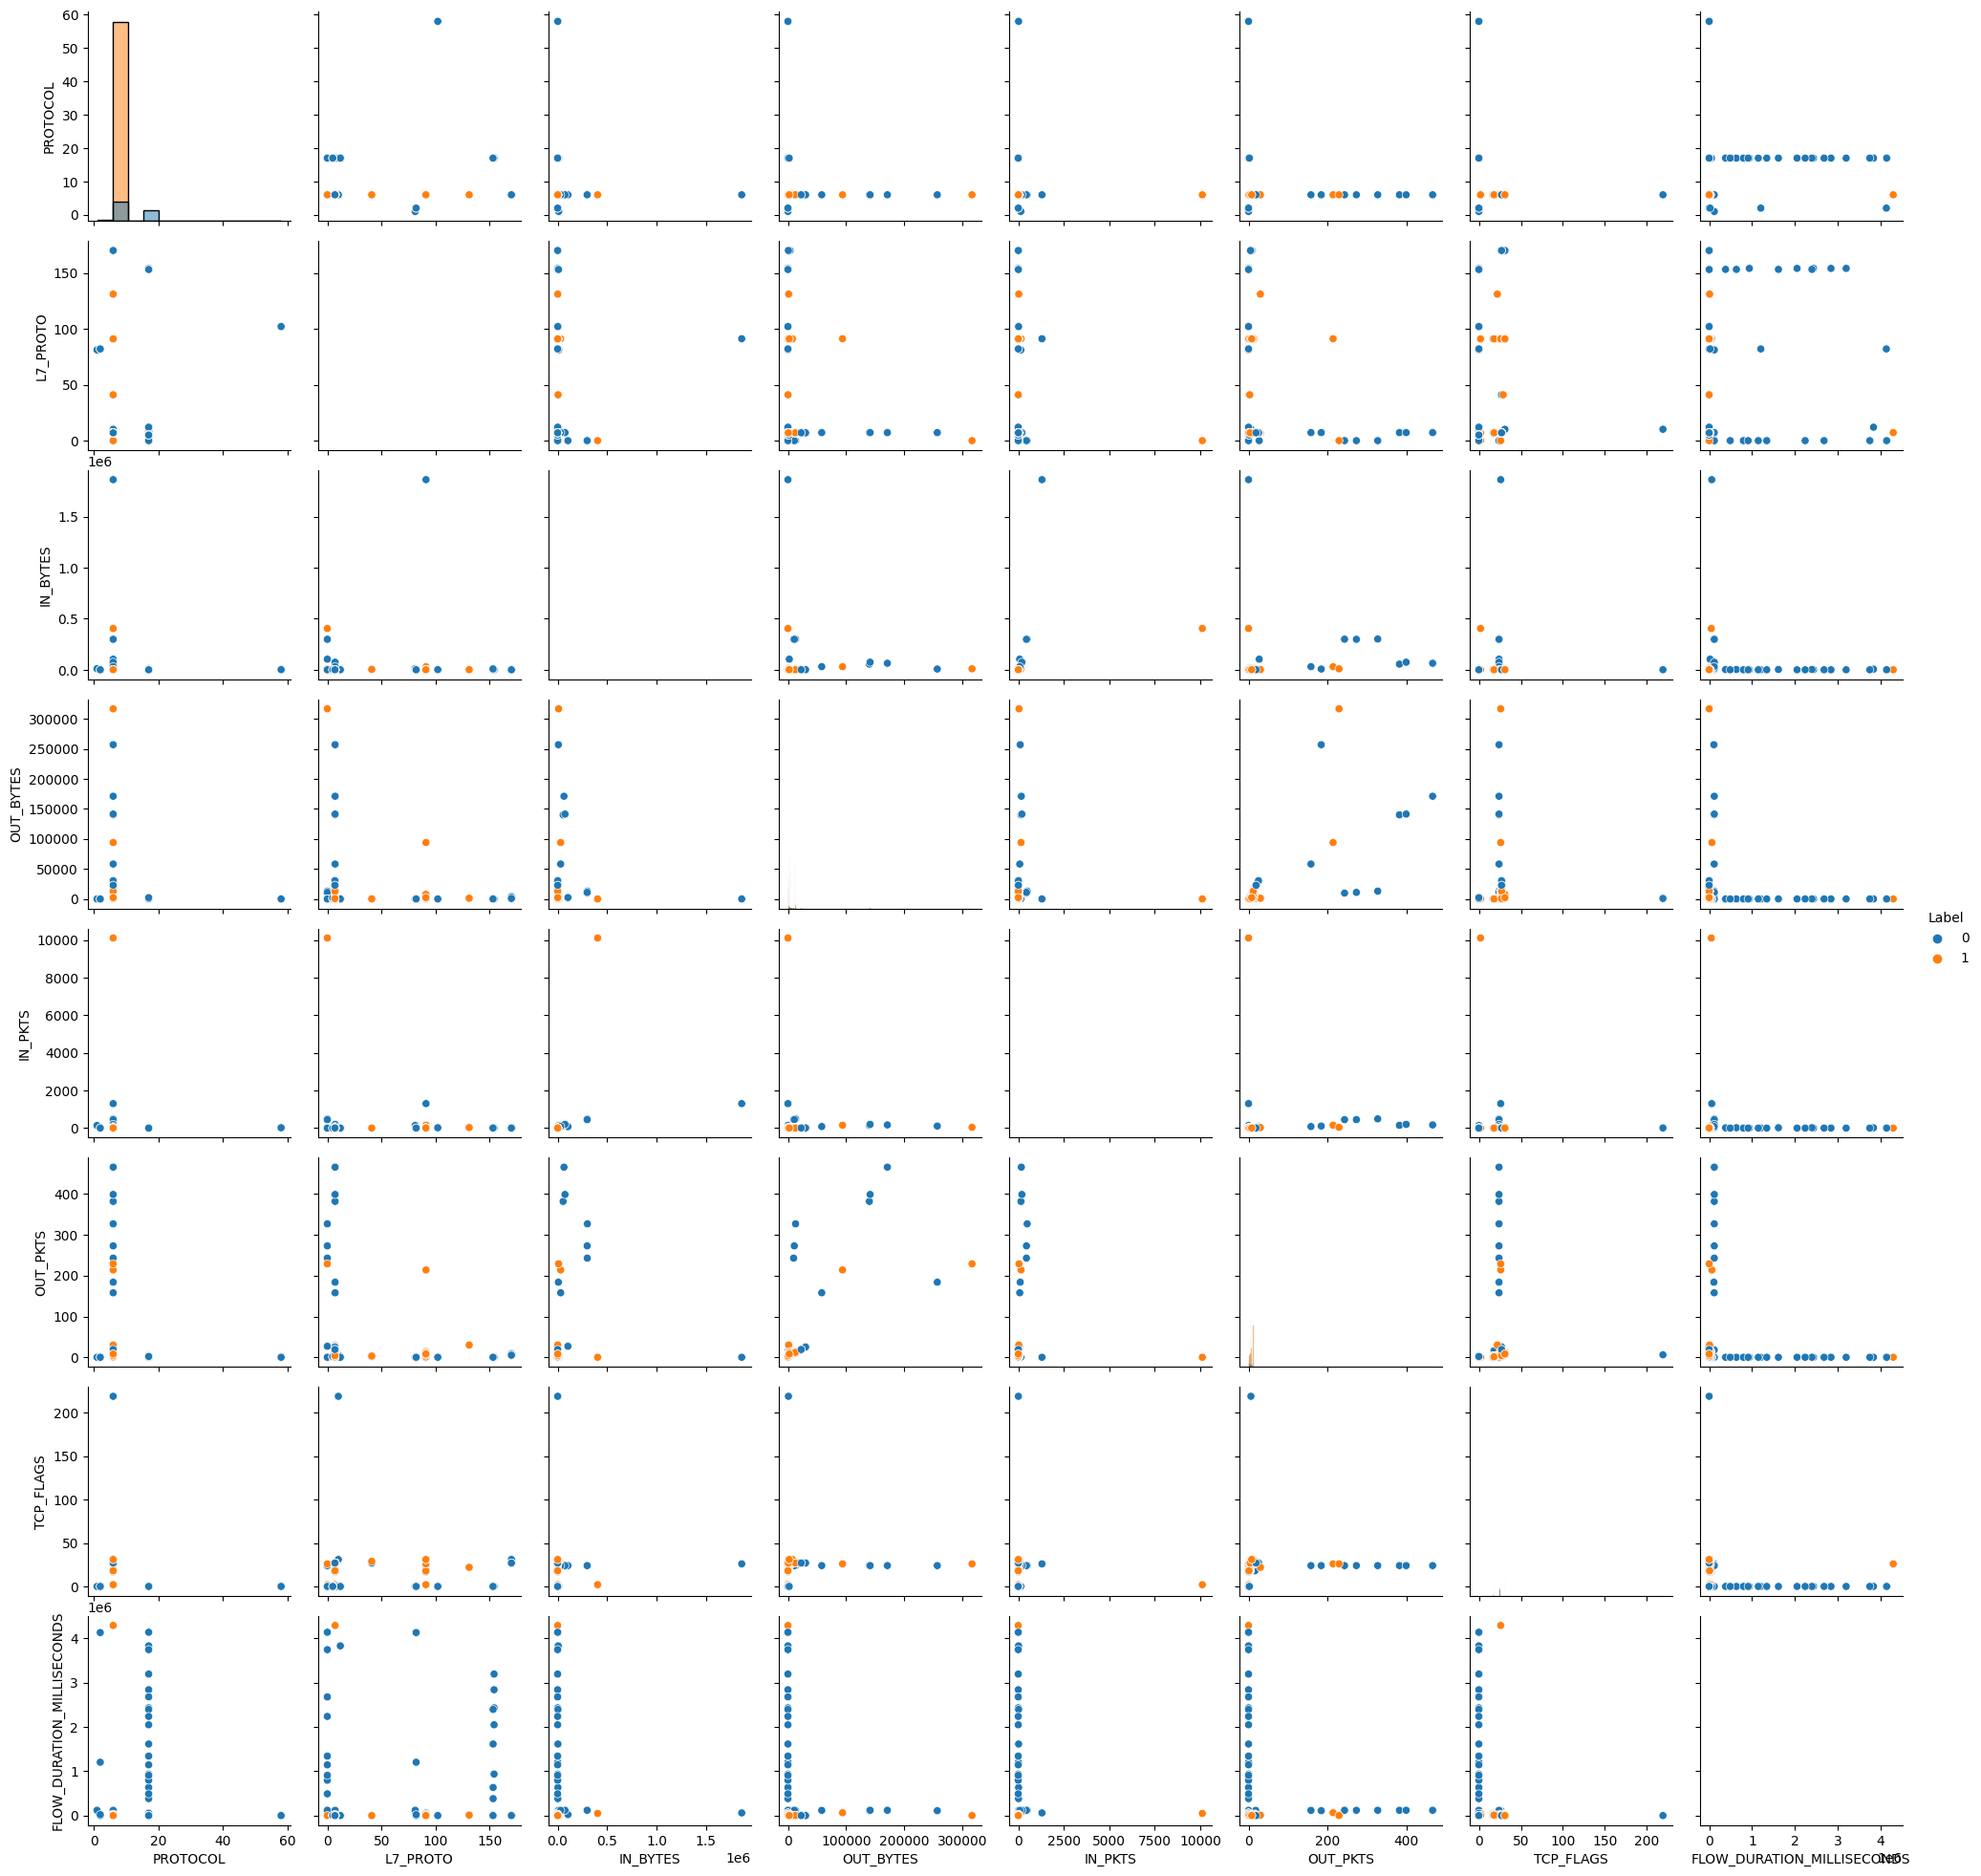

In [8]:
df2 = df_ToN.sample(n=2000, random_state=1)

matrix = df2.corr()
plt.subplots(figsize=(20,15))
sn.heatmap(matrix)#, annot=True)
plt.show()

g = sn.PairGrid(df2, hue="Label")
g.map_diag(sn.histplot)
g.map_offdiag(sn.scatterplot)
g.add_legend()

In [9]:
df_BoT = df_BoT.sample(frac=1).reset_index(drop=True)
df = pd.concat([df_BoT, df_ToN]).reset_index(drop=True)

In [10]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [11]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [12]:
l2 = df_BoT.shape[0]
l1 = int(0.9*l2)

In [13]:
#Train dataset
X_train = X[:l1]
y_train = y[:l1]

#Train dataset
X_val = X[l1:l2]
y_val = y[l1:l2]

#Test dataset
X_test = X[l2:]
y_test = y[l2:]

In [14]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [15]:
rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [16]:
y_pred_val = rf_classifier.predict(X_val)
#print(np.concatenate((y_pred_val.reshape(len(y_pred_val),1), y_val.reshape(len(y_val),1)),1))

cm = confusion_matrix(y_val, y_pred_val)
print(cm)
accuracy_score(y_val, y_pred_val)

[[ 296   22]
 [  14 3673]]


0.9910112359550561

In [17]:
y_pred = rf_classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 22113  30924]
 [  8778 319384]]


0.895849674317089